# Distinguish Your Own Digits (DYOD)

You are going to write a classifier that distinguishes between the number 3 and number 8.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

From the command line run `pip install mnist`. This is a library that will help you bring down the mnist dataset. If you run this from a notebook, you need to put  `!pip install mnist` in a cell by itself.

In [3]:
!pip install mnist

## Preparing the Data

In [4]:
import mnist

In [5]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()

In [6]:
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [7]:
test_images = mnist.test_images()
test_labels = mnist.test_labels()

In [8]:
test_images.shape, test_labels.shape

((10000, 28, 28), (10000,))

2


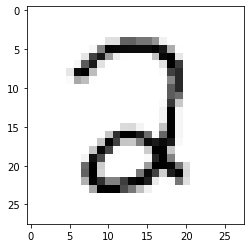

In [9]:
image_index = 7776 # You may select anything up to 60,000
print(train_labels[image_index]) 
plt.imshow(train_images[image_index], cmap='Greys')

## Filter data to get 3 and 8 out

In [10]:
train_filter = np.where((train_labels == 3 ) | (train_labels == 8))
test_filter = np.where((test_labels == 3) | (test_labels == 8))
X_train, y_train = train_images[train_filter], train_labels[train_filter]
X_test, y_test = test_images[test_filter], test_labels[test_filter]

We normalize the pizel values in the 0 to 1 range

In [11]:
X_train = X_train/255.
X_test = X_test/255.

And setup the labels as 1 (when the digit is 3) and 0 (when the digit is 8)

In [12]:
y_train = 1*(y_train==3)
y_test = 1*(y_test==3)

In [13]:
X_train.shape, X_test.shape

((11982, 28, 28), (1984, 28, 28))

We reshape the data to flatten the image pixels into a set of features or co-variates:

In [14]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train.shape, X_test.shape

((11982, 784), (1984, 784))

In [15]:
#Impoting functions from 'Kudzu'
from kudzu.model import Model
from kudzu.train import Learner
from kudzu.optim import GD
from kudzu.data import Data, Sampler,Dataloader

from kudzu.callbacks import AccCallback
from kudzu.callbacks import ClfCallback

from kudzu.loss import MSE

from kudzu.layer import Sigmoid,Relu
from kudzu.layer import Affine

### Let us create a `Config` class, to store important parameters. 
This class essentially plays the role of a dictionary.

In [16]:
class Config:
    pass
config = Config()
config.lr = 0.001
config.num_epochs = 250
config.bs = 50

### Running Models with the Training data
Details about the network layers:
- A first affine layer has 784 inputs and does 100 affine transforms. These are followed by a Relu
- A second affine layer has 100 inputs from the 100 activations of the past layer, and does 100 affine transforms. These are followed by a Relu
- A third affine layer has 100 activations and does 2 affine transformations to create an embedding for visualization. There is no non-linearity here.
- A final "logistic regression" which has an affine transform from 2 inputs to 1 output, which is squeezed through a sigmoid.


In [17]:
data = Data(X_train, y_train.reshape(-1,1))
sampler = Sampler(data, config.bs, shuffle=True)

dl = Dataloader(data, sampler)

opt = GD(config.lr)
loss = MSE()

In [18]:
training_data_x = X_train
testing_data_x = X_test
training_data_y = y_train.reshape(-1,1)
testing_data_y = y_test.reshape(-1,1)

In [19]:
layers = [Affine("first", 784, 100), Relu("first"), Affine("second", 100, 100), Relu("second"), Affine("third", 100, 2), Affine("last", 2, 1), Sigmoid("last")]
model_nn = Model(layers)
model_lr = Model([Affine("logits", 784, 1), Sigmoid("sigmoid")])

xavier
xavier
xavier
xavier
xavier


In [20]:
nn_learner = Learner(loss, model_nn, opt, config.num_epochs)
acc_nn = ClfCallback(nn_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
nn_learner.set_callbacks([acc_nn])

In [21]:
lr_learner = Learner(loss, model_lr, opt, config.num_epochs)
acc_lr = ClfCallback(lr_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
lr_learner.set_callbacks([acc_lr])

In [22]:
nn_learner.train_loop(dl)

Epoch 0, Loss 0.2539
Training Accuracy: 0.2969, Testing Accuracy: 0.3140



Epoch 10, Loss 0.2502
Training Accuracy: 0.4700, Testing Accuracy: 0.4808



Epoch 20, Loss 0.2473
Training Accuracy: 0.5707, Testing Accuracy: 0.5660



Epoch 30, Loss 0.2369
Training Accuracy: 0.7482, Testing Accuracy: 0.7329



Epoch 40, Loss 0.1812
Training Accuracy: 0.8529, Testing Accuracy: 0.8523



Epoch 50, Loss 0.0919
Training Accuracy: 0.9075, Testing Accuracy: 0.9183



Epoch 60, Loss 0.0598
Training Accuracy: 0.9368, Testing Accuracy: 0.9425



Epoch 70, Loss 0.0469
Training Accuracy: 0.9478, Testing Accuracy: 0.9556



Epoch 80, Loss 0.0404
Training Accuracy: 0.9545, Testing Accuracy: 0.9632



Epoch 90, Loss 0.0365
Training Accuracy: 0.9590, Testing Accuracy: 0.9652



Epoch 100, Loss 0.0339
Training Accuracy: 0.9610, Testing Accuracy: 0.9667



Epoch 110, Loss 0.0319
Training Accuracy: 0.9625, Testing Accuracy: 0.9667



Epoch 120, Loss 0.0304
Training Accuracy: 0.9643, Testing Accuracy: 0.9667



Epoch 130, Loss 0.0292
Training Accuracy: 0.9655, Testing Accuracy: 0.9652



Epoch 140, Loss 0.0281
Training Accuracy: 0.9673, Testing Accuracy: 0.9662



Epoch 150, Loss 0.0272
Training Accuracy: 0.9688, Testing Accuracy: 0.9677



Epoch 160, Loss 0.0264
Training Accuracy: 0.9696, Testing Accuracy: 0.9667



Epoch 170, Loss 0.0257
Training Accuracy: 0.9703, Testing Accuracy: 0.9667



Epoch 180, Loss 0.025
Training Accuracy: 0.9710, Testing Accuracy: 0.9672



Epoch 190, Loss 0.0245
Training Accuracy: 0.9715, Testing Accuracy: 0.9682



Epoch 200, Loss 0.0239
Training Accuracy: 0.9726, Testing Accuracy: 0.9682



Epoch 210, Loss 0.0234
Training Accuracy: 0.9731, Testing Accuracy: 0.9682



Epoch 220, Loss 0.0229
Training Accuracy: 0.9737, Testing Accuracy: 0.9698



Epoch 230, Loss 0.0225
Training Accuracy: 0.9743, Testing Accuracy: 0.9693



Epoch 240, Loss 0.0221
Training Accuracy: 0.9750, Testing Accuracy: 0.9688



0.0030777311202696183

In [23]:
lr_learner.train_loop(dl)

Epoch 0, Loss 0.2299
Training Accuracy: 0.6997, Testing Accuracy: 0.6880



Epoch 10, Loss 0.106
Training Accuracy: 0.8991, Testing Accuracy: 0.9047



Epoch 20, Loss 0.0808
Training Accuracy: 0.9241, Testing Accuracy: 0.9365



Epoch 30, Loss 0.069
Training Accuracy: 0.9352, Testing Accuracy: 0.9486



Epoch 40, Loss 0.0619
Training Accuracy: 0.9417, Testing Accuracy: 0.9546



Epoch 50, Loss 0.0572
Training Accuracy: 0.9455, Testing Accuracy: 0.9587



Epoch 60, Loss 0.0537
Training Accuracy: 0.9485, Testing Accuracy: 0.9587



Epoch 70, Loss 0.0511
Training Accuracy: 0.9506, Testing Accuracy: 0.9587



Epoch 80, Loss 0.049
Training Accuracy: 0.9521, Testing Accuracy: 0.9617



Epoch 90, Loss 0.0473
Training Accuracy: 0.9534, Testing Accuracy: 0.9617



Epoch 100, Loss 0.0458
Training Accuracy: 0.9543, Testing Accuracy: 0.9637



Epoch 110, Loss 0.0446
Training Accuracy: 0.9550, Testing Accuracy: 0.9652



Epoch 120, Loss 0.0435
Training Accuracy: 0.9556, Testing Accuracy: 0.9657



Epoch 130, Loss 0.0426
Training Accuracy: 0.9565, Testing Accuracy: 0.9657



Epoch 140, Loss 0.0418
Training Accuracy: 0.9571, Testing Accuracy: 0.9667



Epoch 150, Loss 0.041
Training Accuracy: 0.9578, Testing Accuracy: 0.9662



Epoch 160, Loss 0.0404
Training Accuracy: 0.9584, Testing Accuracy: 0.9662



Epoch 170, Loss 0.0398
Training Accuracy: 0.9590, Testing Accuracy: 0.9662



Epoch 180, Loss 0.0392
Training Accuracy: 0.9597, Testing Accuracy: 0.9667



Epoch 190, Loss 0.0387
Training Accuracy: 0.9599, Testing Accuracy: 0.9662



Epoch 200, Loss 0.0382
Training Accuracy: 0.9601, Testing Accuracy: 0.9662



Epoch 210, Loss 0.0378
Training Accuracy: 0.9603, Testing Accuracy: 0.9667



Epoch 220, Loss 0.0374
Training Accuracy: 0.9606, Testing Accuracy: 0.9667



Epoch 230, Loss 0.037
Training Accuracy: 0.9608, Testing Accuracy: 0.9667



Epoch 240, Loss 0.0366
Training Accuracy: 0.9610, Testing Accuracy: 0.9667



0.036708651836780855

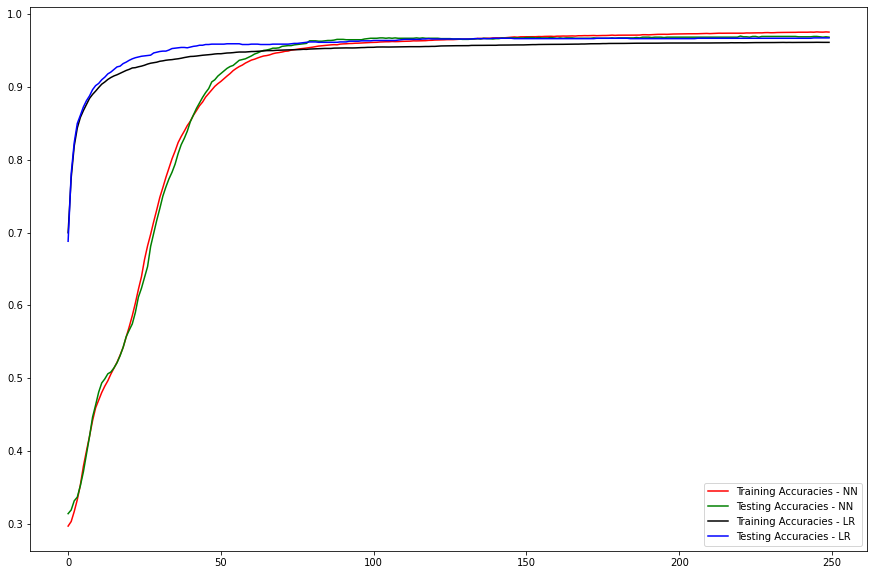

In [24]:
#comparing the results of NN and LR
plt.figure(figsize=(15,10))

# Neural Network plots
plt.plot(acc_nn.accuracies, 'r-', label = "Training Accuracies - NN")
plt.plot(acc_nn.test_accuracies, 'g-', label = "Testing Accuracies - NN")

# Logistic Regression plots
plt.plot(acc_lr.accuracies, 'k-', label = "Training Accuracies - LR")
plt.plot(acc_lr.test_accuracies, 'b-', label = "Testing Accuracies - LR")
plt.legend()

#### Plotting the outputs of this layer of the NN.


In [25]:
new_model = Model(layers[:-2])
testing_plot = new_model(testing_data_x)

Text(0.5, 1.0, 'Outputs')

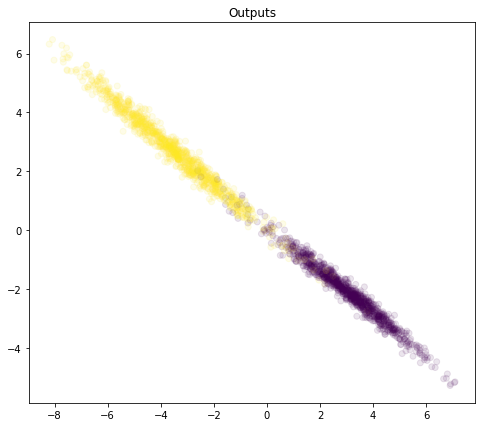

In [26]:
# Plotting the scatter plot of points and color coding by class
plt.figure(figsize=(8,7))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel());
plt.title('Outputs')

Probability contours

In [27]:
model_prob = Model(layers[-2:]) 

In [28]:
#creating the x and y ranges according to the above generated plot.
x_range = np.linspace(-4, 1, 100) 
y_range = np.linspace(-6, 6, 100) 
x_grid, y_grid = np.meshgrid(x_range, y_range) # x_grid and y_grig are of size 100 X 100

# converting x_grid and y_grid to continuous arrays
x_gridflat = np.ravel(x_grid)
y_gridflat = np.ravel(y_grid)

# The last layer of the current model takes two columns as input. Hence transpose of np.vstack() is required.
X = np.vstack((x_gridflat, y_gridflat)).T

prob_contour = model_prob(X).reshape(100,100) 

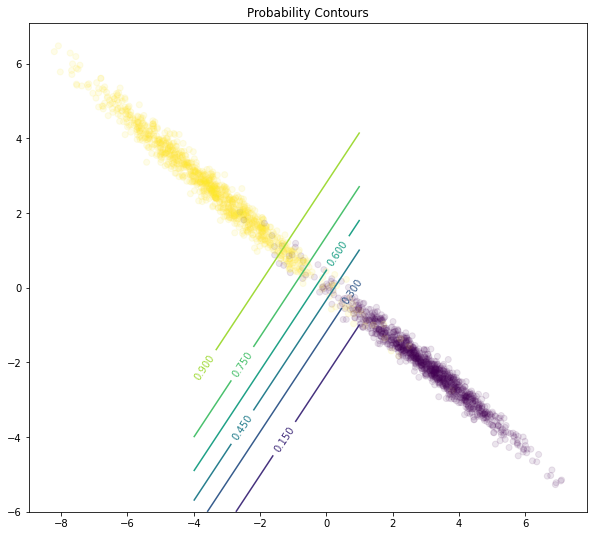

In [29]:
plt.figure(figsize=(10,9))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel())
contours = plt.contour(x_grid,y_grid,prob_contour)
plt.title('Probability Contours')
plt.clabel(contours, inline = True );